# 1) Read in the ASCII file containing the MW mass profile

In [1]:
import numpy as np

data = np.loadtxt( "MW_enclosed_mass_profile.txt",  )

MW_r_vals = data[:,0]
MW_M_star = data[:,1:4]  # maxium likelihood value; 68% interval (lower and upper bound)
MW_M_bar  = data[:,4:7]
MW_M_DM   = data[:,7:10]
MW_M_total= data[:,10:14]

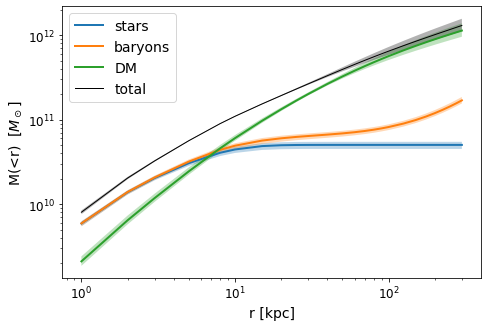

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7.5,5)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2


plt.fill_between( MW_r_vals, MW_M_star[:,0]+MW_M_star[:,1], MW_M_star[:,0]+MW_M_star[:,2], alpha=0.3 )
plt.loglog( MW_r_vals, MW_M_star[:,0], label="stars" )

plt.fill_between( MW_r_vals, MW_M_bar[:,0]+MW_M_bar[:,1], MW_M_bar[:,0]+MW_M_bar[:,2], alpha=0.3 )
plt.loglog( MW_r_vals, MW_M_bar[:,0], label="baryons" )

plt.fill_between( MW_r_vals, MW_M_DM[:,0]+MW_M_DM[:,1], MW_M_DM[:,0]+MW_M_DM[:,2], alpha=0.3 )
plt.loglog( MW_r_vals, MW_M_DM[:,0], label="DM" )

plt.fill_between( MW_r_vals, MW_M_total[:,0]+MW_M_total[:,1], MW_M_total[:,0]+MW_M_total[:,2], fc='k', alpha=0.3 )
plt.loglog( MW_r_vals, MW_M_total[:,0], c="k", lw=1, label="total" )

plt.xlabel( "r [kpc]" )
plt.ylabel( r"M(<r)  $[M_\odot]$" )
plt.legend(  )


plt.savefig('./figures/MW_components.png')

# 2) Calculate the contracted DM profile

## 2.1) First for the DM enclosed mass

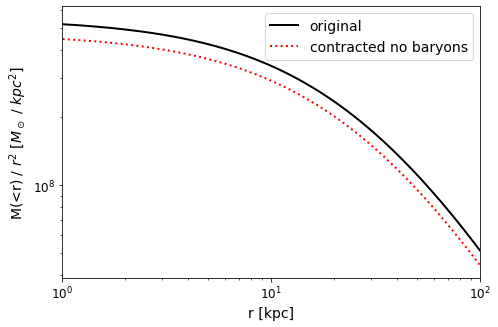

In [3]:
# calculate the contracted mass profile for a 1.e12 halo assuming zero baryons

from Cautun20_contraction import contract_enclosed_mass, NFW_enclosed_mass
import numpy as np

r = np.logspace( -2, 2, 241 )
mass_total = NFW_enclosed_mass( r, M200=1.e12, conc=9 )      # total mass
f_bar      = 0.157   # cosmic baryon fraction
mass_DM    = mass_total * (1.-f_bar)  # DM mass
mass_bar   = 0.                       # no baryons
mass_DM_contracted = contract_enclosed_mass( mass_DM, mass_bar, f_bar=f_bar )

plt.loglog( r, mass_DM / r**2, 'k-', label="original" )
plt.loglog( r, mass_DM_contracted / r**2, 'r:', label="contracted no baryons" )

plt.xlim([1.,100])
plt.xlabel( "r [kpc]" )
plt.ylabel( r"M(<r) / $r^2$ $[M_\odot \ / \ kpc^2]$" )
plt.legend()

plt.savefig('./figures/Contraction_no_baryons.png')

In [4]:
# can calculate the profile of the same halo but using the MW baryonic distribution
# for this to work, you need to have loaded the file containing the MW mass profile

# first lets interpolates the MW enclosed baryonic mass to the new 'r' values
mass_bar_MW = np.interp( r, MW_r_vals, MW_M_bar[:,0] )

mass_DM_contracted_MW = contract_enclosed_mass( mass_DM, mass_bar_MW, f_bar=f_bar )

# The above calculation make senses only for r>1 kpc since the input file does not contain mass values 
# for lower distances, so, when plotting, we only show the range r > 1 kpc.
valid_MW = r > 1.

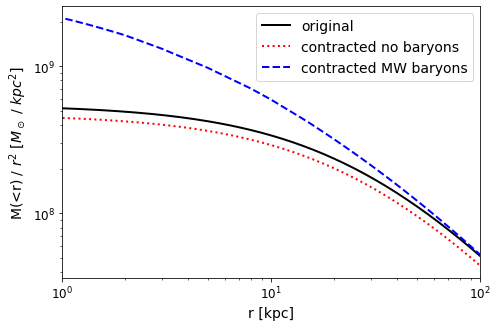

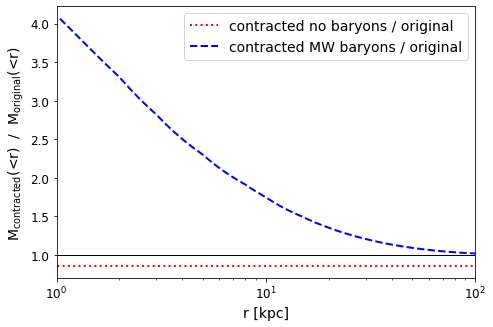

In [5]:
# plot the enclosed mass (actually plots mass / r^2 to decrease the dynamical range)
import matplotlib.pyplot as plt

plt.loglog( r, mass_DM / r**2, 'k-', label="original" )
plt.loglog( r, mass_DM_contracted / r**2, 'r:', label="contracted no baryons" )
plt.loglog( r[valid_MW], (mass_DM_contracted_MW / r**2)[valid_MW], 'b--', label="contracted MW baryons" )

plt.xlim([1.,100])
plt.xlabel( "r [kpc]" )
plt.ylabel( r"M(<r) / $r^2$ $[M_\odot \ / \ kpc^2]$" )
plt.legend()

plt.savefig('./figures/Contraction_MW_baryons.png')
plt.show()


plt.plot( [1.,100.], [1.,1.], 'k-', lw=1 )
plt.semilogx( r, mass_DM_contracted / mass_DM,  'r:', label="contracted no baryons / original" )
plt.semilogx( r[valid_MW], (mass_DM_contracted_MW / mass_DM)[valid_MW], 'b--', label="contracted MW baryons / original" )

plt.xlim( [1,100] )
plt.xlabel( "r [kpc]" )
plt.ylabel( r"M$_{\rm contracted}$(<r)  /  M$_{\rm original}$(<r)" )
plt.legend()

## 2.2) Second, for the DM density profile

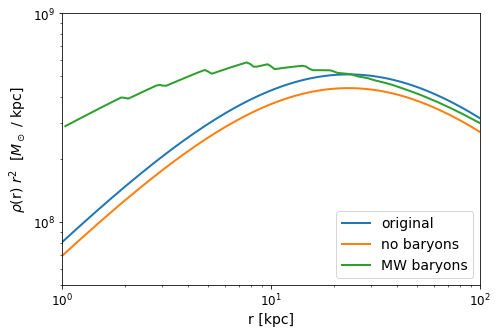

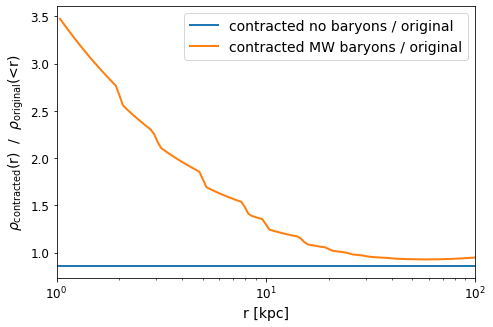

In [7]:
# apply the contraction to the density distribution
from Cautun20_contraction import contract_density, NFW_density, density_from_enclosed_mass
from Cautun20_contraction import contract_density_fit

# First apply to the case of zero baryons
# For this, we calculate the NFW radial density profile for the DM component for the same
# halo used for the enclosed mass calculation.
density_NFW = NFW_density( r, M200=1.e12, conc=9 ) * (1.-f_bar)

# Note: the enclosed mass and the density need to match and be defined at the same set of radial distances
density_DM_contracted = contract_density( density_NFW, 0., mass_DM=mass_DM, mass_bar=mass_bar, f_bar=f_bar )


# Now apply to the MW baryonic distribution.
# For this, we need to calculate the baryonic density -- this is rather noisy due to the
# small number of bins available in the input file and is shown here only for illustration purposes.
den_bar_MW = density_from_enclosed_mass( r, mass_bar_MW, r )
density_DM_contracted_MW = contract_density( density_NFW, den_bar_MW, \
                                         mass_DM=mass_DM, mass_bar=mass_bar_MW, f_bar=f_bar )


plt.loglog( r, density_NFW * r**2, label="original" )
plt.loglog( r, density_DM_contracted * r**2, label="no baryons" )
plt.loglog( r[valid_MW], (density_DM_contracted_MW * r**2)[valid_MW], label="MW baryons" )

plt.xlim( [1,100] )
plt.ylim( [5.e7,1.e9] )
plt.xlabel( "r [kpc]" )
plt.ylabel( r"$\rho$(r) $r^2$  $[M_\odot \ / \ \rm{kpc}]$" )
plt.legend()
plt.show()

plt.semilogx( r, density_DM_contracted / density_NFW, label="contracted no baryons / original" )
plt.semilogx( r[valid_MW], (density_DM_contracted_MW / density_NFW)[valid_MW], \
             label="contracted MW baryons / original" )

plt.xlim( [1,100] )
plt.xlabel( "r [kpc]" )
plt.ylabel( r"$\rho_{\rm contracted}$(r)  /  $\rho_{\rm original}$(<r)" )
plt.legend()


# 3) Import the MW potential and use it in galpy

In [8]:
# import the MW best fitting potential as determined by Cautun et al (2020)
from Cautun20_galpy_potential import Cautun20

# Can also import individual potentials: 4 components are available: 
# 1) DM halo, 
# 2) one component represneting all disks: stellar thin + thick, HI and molecular gas disks
# 3) the stellar bulge
# 4) the CGM (i.e. hot gaseous halo)
Cautun_halo, Cautun_Discs, Cautun_Bulge, Cautun_cgm = Cautun20

# Can also import various spherically averaged masses and densities
# All these quanties are in internal galpy units!
# rspace - the (spherical) radial bins at which the quantities are defined
# rho_DM_contracted - the contracted DM density profile
# MassCum_DM_contracted - the enclosed DM mass for the contracted halo
# MassCum_bar - spherically averaged enclosed baryonic mass
# MassCum_DM_uncontracted - the enclosed DM mass before baryonic contraction
from Cautun20_galpy_potential import rspace, rho_DM_contracted, MassCum_DM_contracted, MassCum_bar, MassCum_DM_uncontracted

import numpy as np
import matplotlib.pyplot as plt

  Referenced from: /Users/marius/Library/Python/3.7/lib/python/site-packages/libgalpy.cpython-37m-darwin.so
  Reason: image not found' 


<Figure size 540x360 with 0 Axes>

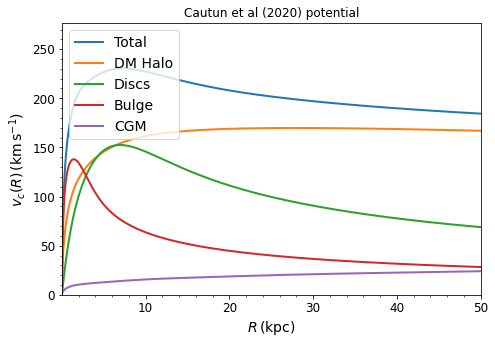

In [9]:
# Plot the rotation curve and the various components: DM halo, bulge, discs, and CGM
from galpy.potential import plotRotcurve, vcirc

Rmax = 50 #100    # in units of R0
Rrange = [0.01,Rmax]


plt.figure()
plotRotcurve(     Cautun20, label='Total', Rrange=Rrange )
plotRotcurve(  Cautun_halo, label='DM Halo', Rrange=Rrange, overplot=True)
plotRotcurve( Cautun_Discs, label='Discs',  Rrange=Rrange, overplot=True)
plotRotcurve( Cautun_Bulge, label='Bulge', Rrange=Rrange, overplot=True)
plotRotcurve(   Cautun_cgm, label='CGM',   Rrange=Rrange, overplot=True)

plt.title('Cautun et al (2020) potential')
plt.legend()

plt.savefig('./figures/MW_components_Vcirc.png')

Error loading the 'MWPotential2014' potential!


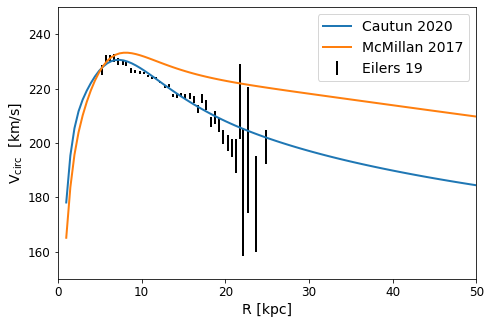

In [11]:
# Compare the rotation curve with some recent data and with two other galpy potentials
from galpy.potential.mwpotentials import MWPotential2014, McMillan17


# read the Eilers et al (2019) rotation curve data
MW_Vrot_data = np.loadtxt('MW_rotation_Eilers_2019.txt')
vdata_r    = MW_Vrot_data[:,0]
vdata_vc   = MW_Vrot_data[:,1]
vdata_vc_u = MW_Vrot_data[:,2]
vdata_vc_l = MW_Vrot_data[:,3]

# compare the various rotation curves with the data
R0 = 8.122    # Solar position in kpc
rvals  = np.linspace( 1., 50., 101 )  # kpc
plt.figure()

plt.errorbar( vdata_r, vdata_vc, yerr=[vdata_vc_l, vdata_vc_u], c='k', label='Eilers 19', ls='', zorder=-1 )
plt.plot( rvals, vcirc( Cautun20, rvals/R0, 0 ), label='Cautun 2020' )
plt.plot( rvals, vcirc( McMillan17, rvals/R0, 0 ), label='McMillan 2017' )

if vcirc( MWPotential2014, 1, 0 ) < 200. :
    print( "Error loading the 'MWPotential2014' potential!" )
else: 
    plt.plot( rvals, vcirc( MWPotential2014, rvals/R0, 0 ), label='Bovy 2015' )

# plotRotcurve(     Cautun20, label='Cautun 2020', Rrange=Rrange, overplot=True )
# plotRotcurve( MWPotential2014, label='Bovy 2015', Rrange=Rrange, overplot=True )
# plotRotcurve(     McMillan17, label='McMillan 2017', Rrange=Rrange, overplot=True )

plt.ylim( [150,250] )
plt.xlim( [0,50] )
plt.xlabel( "R [kpc]" )
plt.ylabel( r"V$_{\rm circ}$  [km/s]" )
plt.legend()
plt.savefig('./figures/Cautun20_vs_McMillan17.png')